# RNN training attempt 03 (chords only)

Per BC's advice, we will first try to generate just chord sequences. We will first filter the dataset further to get rid of diminished chords. We will also encode the relative position of each note within either a 1-measure or 2-measure chunk as a binary vector.

## Setup

In [ ]:
# First mount your Google drive
from google.colab import drive
drive.mount('/content/gdrive')

# We'll use the note/chord encodings from simple feedforward as a starting point
ff_path = 'gdrive/My Drive/Colab Notebooks/Thesis/simple-feedforward' # change this if needed

# Imports
import os
import numpy as np
import pickle as pkl
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.special import softmax

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Load data

### Import from simple-feedforward

In [ ]:
# Load encoded notes and chords
encoded_notes_path = os.path.join(ff_path, "encoded_notes.npy")
encoded_chords_path = os.path.join(ff_path, "encoded_chords.npy")
encoded_notes = np.load(encoded_notes_path)
encoded_chords = np.load(encoded_chords_path)

# Load song names
song_names_path = os.path.join(ff_path, "song_names.pkl")
opened_file = open(song_names_path, "rb")
song_names = pkl.load(opened_file)
opened_file.close()

num_hooks = len(song_names)
print(f"Loaded data. Number of 8-bar hooks: {num_hooks}")

Loaded data. Number of 8-bar hooks: 3448


### Reshape into 3D tensors

In [ ]:
OLD_NOTE_ONE_HOT_VECTOR_LENGTH = 38
OLD_CHORD_ONE_HOT_VECTOR_LENGTH = 32
NUM_16_NOTES_IN_8_BARS = 128

encoded_notes = encoded_notes.reshape((num_hooks, OLD_NOTE_ONE_HOT_VECTOR_LENGTH, NUM_16_NOTES_IN_8_BARS), order='F')
encoded_chords = encoded_chords.reshape((num_hooks, OLD_CHORD_ONE_HOT_VECTOR_LENGTH, NUM_16_NOTES_IN_8_BARS), order='F')

print(encoded_notes.shape)
print(encoded_chords.shape)

(3448, 38, 128)
(3448, 32, 128)


## Preprocess chords

### Check how many hooks have diminished chords

First get a list of the chord one-hot indices that correspond to diminished chords

In [ ]:
old_allowed_chords = [
    '00-dim',
    '00-maj',
    '00-min',
    '01-dim',
    '01-maj',
    '02-dim',
    '02-maj',
    '02-min',
    '03-dim',
    '03-maj',
    '03-min',
    '04-dim',
    '04-maj',
    '04-min',
    '05-maj',
    '05-min',
    '06-dim',
    '06-maj',
    '07-dim',
    '07-maj',
    '07-min',
    '08-dim',
    '08-maj',
    '09-dim',
    '09-maj',
    '09-min',
    '10-maj',
    '10-min',
    '11-dim',
    '11-maj',
    '11-min'
]
# Get a list of the one-hot indices that correspond to diminished chords
def get_dim_idxs():
    dim_idxs = []
    for idx in range(len(old_allowed_chords)):
        chord_str = old_allowed_chords[idx]
        if chord_str[3:6] == "dim":
            dim_idxs.append(idx + 1) # +1 because idx 0 is reserved for holds

    return dim_idxs

dim_idxs = get_dim_idxs()
print("One-hot indices for diminished chords:")
print(dim_idxs)

One-hot indices for diminished chords:
[1, 4, 6, 9, 12, 17, 19, 22, 24, 29]


Now count the number of hooks that have these chord indices

In [ ]:
# Given the encoded chords of a hook, return a bool for whether or not the hook
# has diminished chords
def has_dim(hook):
    ret = False
    for timestep in range(len(hook[0])):
        vect = hook[:, timestep]
        idx = np.argmax(vect)
        if idx in dim_idxs:
            ret = True
            break
    return ret

# Count the number of hooks with diminished chords in the dataset
def count_num_hooks_with_dim():
    count = 0
    for hook in encoded_chords:
        if has_dim(hook):
            count += 1
    return count

num_hooks_with_dim = count_num_hooks_with_dim()
print(f"Number of hooks with diminished chords: {num_hooks_with_dim}")

Number of hooks with diminished chords: 196


Okay yeah let's get rid of them all.

### Remove all songs from dataset with diminished chords

In [ ]:
# Setup
encoded_notes_filt = []
encoded_chords_filt = []
song_names_filt = []
num_removed = 0

# Only keep hooks without diminished chords
for i in range(len(song_names)):
    if not has_dim(encoded_chords[i]):
        encoded_notes_filt.append(encoded_notes[i])
        encoded_chords_filt.append(encoded_chords[i])
        song_names_filt.append(song_names[i])
    else:
        num_removed += 1

# Convert to numpy arrays
encoded_notes_filt = np.array(encoded_notes_filt)
encoded_chords_filt = np.array(encoded_chords_filt)

# Reassign vars
encoded_notes = encoded_notes_filt
encoded_chords = encoded_chords_filt
song_names = song_names_filt

print(f"Number of hooks with diminished chords that were removed: {num_removed}")
print("Shapes:")
print(encoded_notes.shape)
print(encoded_chords.shape)
print(f"Number of hooks: {len(song_names)}")

Number of hooks with diminished chords that were removed: 196
Shapes:
(3252, 38, 128)
(3252, 32, 128)
Number of hooks: 3252


### Removed the diminished chord indices from the chord one-hot representation

In [ ]:
encoded_chords = np.delete(encoded_chords, dim_idxs, 1)
print(encoded_chords.shape)

(3252, 22, 128)


### Create a new list of allowed chords

In [ ]:
allowed_chords = []
for chord_str in old_allowed_chords:
    if chord_str[3:6] != "dim":
        allowed_chords.append(chord_str)

print(f"Number of allowed chords: {len(allowed_chords)} (+1 if including hold)")
for chord_str in allowed_chords:
    print(chord_str)

Number of allowed chords: 21 (+1 if including hold)
00-maj
00-min
01-maj
02-maj
02-min
03-maj
03-min
04-maj
04-min
05-maj
05-min
06-maj
07-maj
07-min
08-maj
09-maj
09-min
10-maj
10-min
11-maj
11-min


### Double check the distribution of the chords. Maybe you can filter others out

In [ ]:
# Helper function: add an item to a distribution map
def add_to_distribution_map(item, map):
    if item not in map:
        map[item] = 1
    else:
        map[item] += 1

# Helper function: print distribution map sorted by key
def print_distribution_map_keysort(map):
    sorted_map = sorted(map.items())
    for item in sorted_map:
        print(item)

# Helper function: print distribution map sorted by # occurences descending
def print_distribution_map_valsort(map):
    sorted_map = sorted(map.items(), key=lambda item: item[1], reverse=True)
    for item in sorted_map:
        print(item)

# Print the distribution of chords that are not holds
def check_chord_dist():
    map = {}
    for hook in encoded_chords:
        for timestep in range(len(hook[0])):
            vect = hook[:, timestep]
            idx = np.argmax(vect)
            add_to_distribution_map(idx, map)
    
    sorted_map = sorted(map.items(), key=lambda item: item[1], reverse=True)
    for item in sorted_map:
        idx = item[0]
        if idx != 0:
            print(f"{allowed_chords[idx - 1]}: {item[1]}")

check_chord_dist()



00-maj: 6301
05-maj: 4955
00-min: 4738
07-maj: 4703
10-maj: 3401
08-maj: 2994
09-min: 2858
03-maj: 2017
02-min: 1559
05-min: 1514
07-min: 1279
04-min: 837
02-maj: 221
04-maj: 156
01-maj: 121
09-maj: 105
10-min: 46
11-min: 22
06-maj: 15
11-maj: 5
03-min: 2


Consider filtering out some of the bottom ones if you have time.

## Preprocess notes (will be relevant later)

This won't impact your chords-only attempt, but you'll definitely use this later.

### Move all notes into a one octave (12-note) range (yes I know it hurts)

Remember that the notes currently span C3 to C6

In [ ]:
# For every hook...
for hook in encoded_notes:
    # For every timestep...
    for timestep in range(len(hook[0])):
        # Find the current one-hot index
        vect = hook[:, timestep]
        idx = np.argmax(vect)

        # If the idx is not the hold idx (0), modulo it to squeeze into
        # a one-octave range, then update the one-hot
        if idx != 0:
            new_idx = ((idx - 1) % 12) + 1
            vect[idx] = 0
            vect[new_idx] = 1

### Remove the extra indices from the note one-hot representation

In [ ]:
encoded_notes = np.delete(encoded_notes, range(13, OLD_NOTE_ONE_HOT_VECTOR_LENGTH), 1)
print(encoded_notes.shape)

# Sanity check: make sure the number of 1s is the same
print(f"Number of 1s in encoded_notes: {np.sum(encoded_notes)}")
print(f"Expected number: {len(encoded_notes) * NUM_16_NOTES_IN_8_BARS}")

(3252, 13, 128)
Number of 1s in encoded_notes: 416256
Expected number: 416256


# AT THIS POINT, CHORDS-ONLY CODE WILL DIVERGE

## Filter durations

### Find distribution of durations for just chords

An event is defined as the beginning of a chord, or timestep 0. Note that timestep 0 is always an event.

In [ ]:
# Find the distribution of durations for just chords
def find_dur_dist_chords_only():
    map = {}

    # For every hook...
    for i in range(len(encoded_chords)):
        # Start at timestep 0
        t = 0

        # Scan for the next non-hold one-hot
        s = t + 1
        while s < NUM_16_NOTES_IN_8_BARS:
            chord_vect = encoded_chords[i, :, s]

            # If we have reached the next event, calcuate duration, add to map, and
            # update pointers
            if np.argmax(chord_vect) != 0:
                dur = s - t
                add_to_distribution_map(dur, map)
                t = s

            # Increment s every time
            s += 1

        # Add the final duration once we've reached the end of hook
        add_to_distribution_map(s - t, map)

    # Print results
    print(f"Number of possible durations: {len(map)}")
    print("\nSorted by duration:")
    print_distribution_map_keysort(map)
    print("\nSorted by # occurrences:")
    print_distribution_map_valsort(map)

    # Print total number of events
    num_events = sum(map.values())
    print(f"\nTotal number of events: {num_events}")

    # Return the map
    return map

duration_dist = find_dur_dist_chords_only()

Number of possible durations: 50

Sorted by duration:
(1, 496)
(2, 3192)
(3, 2094)
(4, 3736)
(5, 116)
(6, 2723)
(7, 187)
(8, 7881)
(9, 154)
(10, 1497)
(11, 18)
(12, 727)
(13, 83)
(14, 482)
(15, 31)
(16, 11774)
(17, 28)
(18, 467)
(19, 5)
(20, 181)
(22, 35)
(23, 1)
(24, 214)
(25, 2)
(26, 83)
(28, 57)
(29, 2)
(30, 7)
(31, 5)
(32, 1447)
(34, 15)
(35, 1)
(36, 10)
(40, 5)
(42, 1)
(44, 3)
(48, 31)
(50, 3)
(52, 4)
(56, 9)
(57, 1)
(58, 2)
(60, 5)
(64, 108)
(68, 1)
(74, 1)
(80, 3)
(84, 1)
(96, 3)
(128, 32)

Sorted by # occurrences:
(16, 11774)
(8, 7881)
(4, 3736)
(2, 3192)
(6, 2723)
(3, 2094)
(10, 1497)
(32, 1447)
(12, 727)
(1, 496)
(14, 482)
(18, 467)
(24, 214)
(7, 187)
(20, 181)
(9, 154)
(5, 116)
(64, 108)
(26, 83)
(13, 83)
(28, 57)
(22, 35)
(128, 32)
(48, 31)
(15, 31)
(17, 28)
(11, 18)
(34, 15)
(36, 10)
(56, 9)
(30, 7)
(60, 5)
(40, 5)
(19, 5)
(31, 5)
(52, 4)
(50, 3)
(80, 3)
(96, 3)
(44, 3)
(58, 2)
(29, 2)
(25, 2)
(42, 1)
(57, 1)
(74, 1)
(35, 1)
(84, 1)
(68, 1)
(23, 1)

Total number of events:

### Only consider hooks that have the top 16 durations (somewhat of an arbitrary threshold choice)

In [ ]:
NUM_ALLOWED_DURATIONS = 16

# Create a list of allowed durations
durations_sorted_by_freq = sorted(duration_dist.items(), key=lambda item: item[1], reverse=True)
durations_top_16 = durations_sorted_by_freq[0:NUM_ALLOWED_DURATIONS]
allowed_durations = []
for item in durations_top_16:
    allowed_durations.append(item[0])

print("Allowed durations (in descending order of frequency):")
print(allowed_durations)

# Scan all hooks and only keep hooks that have allowed event durations
encoded_notes_filt = []
encoded_chords_filt = []
song_names_filt = []

for i in range(len(encoded_notes)):
    t = 0
    s = t + 1
    keep_this_hook = True
    while s < NUM_16_NOTES_IN_8_BARS:
        chord_vect = encoded_chords[i, :, s]

        # If we have reached the next event, calculate the duration and break out
        # if a non-allowed duration has been detected
        if np.argmax(chord_vect) != 0:
            dur = s - t
            if dur not in allowed_durations:
                keep_this_hook = False
                break
            t = s
        
        # Increment s every time
        s += 1

    # Don't forget the last step
    last_dur = s - t
    if last_dur not in allowed_durations:
        keep_this_hook = False
    
    # Decide if the hook should be kept
    if keep_this_hook:
        encoded_notes_filt.append(encoded_notes[i])
        encoded_chords_filt.append(encoded_chords[i])
        song_names_filt.append(song_names[i])

encoded_notes_filt = np.array(encoded_notes_filt)
encoded_chords_filt = np.array(encoded_chords_filt)

# Print number of hooks removed
num_songs_removed = len(encoded_notes) - len(encoded_notes_filt)
print(f"\nNumber of hooks removed: {num_songs_removed}")

# Print shapes
print(encoded_notes_filt.shape)
print(encoded_chords_filt.shape)
print(len(song_names_filt))

Allowed durations (in descending order of frequency):
[16, 8, 4, 2, 6, 3, 10, 32, 12, 1, 14, 18, 24, 7, 20, 9]

Number of hooks removed: 354
(2898, 13, 128)
(2898, 22, 128)
2898


Update vars and check that filtering worked as expected

In [ ]:
encoded_notes = encoded_notes_filt
encoded_chords = encoded_chords_filt
song_names = song_names_filt

duration_dist = find_dur_dist_chords_only()

Number of possible durations: 16

Sorted by duration:
(1, 360)
(2, 2928)
(3, 1709)
(4, 3399)
(6, 2441)
(7, 142)
(8, 7532)
(9, 111)
(10, 1407)
(12, 688)
(14, 449)
(16, 11439)
(18, 443)
(20, 157)
(24, 193)
(32, 1304)

Sorted by # occurrences:
(16, 11439)
(8, 7532)
(4, 3399)
(2, 2928)
(6, 2441)
(3, 1709)
(10, 1407)
(32, 1304)
(12, 688)
(14, 449)
(18, 443)
(1, 360)
(24, 193)
(20, 157)
(7, 142)
(9, 111)

Total number of events: 34702


## Encode dataset in terms of (chord, duration, pos)

"pos" is the relative position of the event encoded as a binary vector. Here we experiment with either a 2-bar chunk (5 bits) or a 1-bar chunk (4 bits).

### Set up helper methods

In [ ]:
# Helper: given a 5-bit positive integer value, return a numpy binary vector
# of length 5 representing the integer
def convert_int_to_5bit(n):
    n_bin = bin(n)
    vect = np.zeros(5, dtype=int)
    i = len(vect) - 1
    for j in range(len(n_bin) - 1, 1, -1):
        vect[i] = int(n_bin[j])
        i -= 1
    return vect

# Helper: given a 4-bit positive integer value, return a numpy binary vector
# of length 4 representing the integer
def convert_int_to_4bit(n):
    n_bin = bin(n)
    vect = np.zeros(4, dtype=int)
    i = len(vect) - 1
    for j in range(len(n_bin) - 1, 1, -1):
        vect[i] = int(n_bin[j])
        i -= 1
    return vect

# Helper: given a 5-bit numpy binary vector, return the integer it represents
def convert_5bit_to_int(v):
    ret = 0
    for i in range(4, -1, -1):
        ret += v[i] * np.power(2, 4 - i)
    return ret

# Helper: given a 4-bit numpy binary vector, return the integer it represents
def convert_4bit_to_int(v):
    ret = 0
    for i in range(3, -1, -1):
        ret += v[i] * np.power(2, 3 - i)
    return ret

# Testing area
print(convert_int_to_5bit(13))
print(convert_int_to_4bit(13))
print(convert_int_to_5bit(31))
print(convert_5bit_to_int(np.array([0, 1, 1, 0, 1])))
print(convert_4bit_to_int(np.array([1, 1, 0, 1])))
print(convert_5bit_to_int(np.array([1, 1, 1, 1, 1])))

[0 1 1 0 1]
[1 1 0 1]
[1 1 1 1 1]
13
13
31


In [ ]:
# Helper: given a timestep value, return a 5-bit binary vector encoding
# where the timestep is within a 2-bar chunk
def get_pos_5bit(timestep):
    relative_timestep = timestep % 32
    return convert_int_to_5bit(relative_timestep)

# Helper: given a timestep value, return a 4-bit binary vector encoding
# where the timestep is within a measure
def get_pos_4bit(timestep):
    relative_timestep = timestep % 16
    return convert_int_to_4bit(relative_timestep)

# Helper: convert a duration into its one-hot vector representation
def duration_to_one_hot(dur):
    one_hot = np.zeros(len(allowed_durations), dtype=int)
    idx = allowed_durations.index(dur)
    one_hot[idx] = 1
    return one_hot

# Testing area
print(np.argmax(duration_to_one_hot(16)))  # should be 0
print(np.argmax(duration_to_one_hot(4)))  # should be 2
print(np.argmax(duration_to_one_hot(9))) # should be 15
print("---")
print(get_pos_5bit(0))
print(get_pos_4bit(0))
print(get_pos_5bit(16))
print(get_pos_4bit(16))
print(get_pos_5bit(127))
print(get_pos_4bit(127))


0
2
15
---
[0 0 0 0 0]
[0 0 0 0]
[1 0 0 0 0]
[0 0 0 0]
[1 1 1 1 1]
[1 1 1 1]


### Set which pos mode you're using (5-bit or 4-bit)

In [ ]:
POS_MODE = "4bit" # either "5bit" or "4bit"

############################

NUM_POS_BITS = 4
get_pos_func = get_pos_4bit
convert_pos_to_int_func = convert_4bit_to_int

if POS_MODE == "5bit":
    NUM_POS_BITS = 5
    get_pos_func = get_pos_5bit
    convert_pos_to_int_func = convert_5bit_to_int

### Do ragged encoding

In [ ]:
encoded_dataset_ragged = []

# Encode the dataset given a pos function (5 bit or 4 bit)
def encode_ragged(get_pos_func):
    # For every hook...
    for i in range(len(encoded_chords)):
        # Start at timestep 0
        t = 0
        events = []
        chord_vect = encoded_chords[i, :, t] # this could be a hold

        # Scan for the next non-hold one-hot
        s = t + 1
        while s < NUM_16_NOTES_IN_8_BARS:
            chord_vect_scan = encoded_chords[i, :, s]

            # If we have reached the next event, encode the current event
            if np.argmax(chord_vect_scan) != 0:
                dur = s - t
                duration_vect = duration_to_one_hot(dur)
                pos_vect = get_pos_func(t)

                # Concatenate vectors and add current event
                event_vect = np.concatenate([chord_vect, duration_vect, pos_vect])
                events.append(event_vect)

                # Move t pointer such that the next event is now the current event
                t = s

                # In this version, update the chord vect every time
                chord_vect = encoded_chords[i, :, t]
                

            # Increment s every time
            s += 1
        
        # Don't forget the final event!
        last_dur = s - t
        last_duration_vect = duration_to_one_hot(last_dur)
        last_pos_vect = get_pos_func(t)
        last_event_vect = np.concatenate([chord_vect, last_duration_vect, last_pos_vect])
        events.append(last_event_vect)

        # Finally, add the hook to your master dataset list
        encoded_dataset_ragged.append(events)




# Let it rip
encode_ragged(get_pos_func)
print(f"Number of hooks processed: {len(encoded_dataset_ragged)}")





# Sanity check: check that the total number of events matches what you found before
total_num_events = 0
for hook in encoded_dataset_ragged:
    total_num_events += len(hook)
print(f"Total number of events: {total_num_events}")

# Print average number of events in each hook
print(f"Average number of events per hook: {total_num_events / len(encoded_dataset_ragged)}")

Number of hooks processed: 2898
Total number of events: 34702
Average number of events per hook: 11.974465148378192


## Set up Music21 dev environment

### Import and install necessary packages

In [ ]:
import music21
from IPython.display import Image, Audio

print("updating apt-get...")
!apt-get update > /dev/null

# enables music21 to render images of musical notes
print("\ninstalling lilypond...")
!apt-get install lilypond > /dev/null
#!apt-get install lilypond

# converts midi files to wav files into order to play them
print("installing fluidsynth...")
!apt-get install fluidsynth > /dev/null
#!apt-get install fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

print('done!')

!fluidsynth --version
!lilypond --version

updating apt-get...

installing lilypond...
installing fluidsynth...
done!
FluidSynth version 1.1.9
Copyright (C) 2000-2018 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

FluidSynth 1.1.9
GNU LilyPond 2.18.2

Copyright (c) 1996--2012 by
  Han-Wen Nienhuys <hanwen@xs4all.nl>
  Jan Nieuwenhuizen <janneke@gnu.org>
  and others.

This program is free software.  It is covered by the GNU General Public
License and you are welcome to change it and/or distribute copies of it
under certain conditions.  Invoke as `lilypond --warranty' for more
information.



These functions will make it easy to show and play back Music21 streams

In [ ]:
# Display the music score
def show(music):
    display(Image(str(music.write('lily.png'))))

# Play the music at a user-specified bpm, or 120 if no bpm specified
def play(music, bpm=120):
    s = music21.stream.Stream()
    s.append(music21.tempo.MetronomeMark(number=bpm))
    s.append(music)
    filename = s.write('mid')
    !fluidsynth -ni font.sf2 $filename -F $filename\.wav -r 16000 > /dev/null
    display(Audio(filename + '.wav'))

### Parse an event vector into its constitutent one-hots (in this case chord, duration and pos)

In [ ]:
CHORD_ONE_HOT_VECTOR_LENGTH = len(encoded_chords[0])
print(f"Chord one-hot length: {CHORD_ONE_HOT_VECTOR_LENGTH}")

# Given a single event (represented as 1D numpy vector), return the chord,
# duration and pos vectors that comprise it
def parse_event_vect(event):
    a = CHORD_ONE_HOT_VECTOR_LENGTH
    b = a + NUM_ALLOWED_DURATIONS
    chord_vect = event[0:a]
    duration_vect = event[a:b]
    pos_vect = event[b:]
    return chord_vect, duration_vect, pos_vect

Chord one-hot length: 22


### Decode a duration one-hot into its integer representation in number of 16-note timesteps

In [ ]:
# Given a one-hot encoding of a duration, return the integer value of the duration
# in number of 16-note timesteps
def decode_duration_one_hot(one_hot):
    idx = np.argmax(one_hot)
    return allowed_durations[idx]

### Chord translation

In [ ]:
# Re-print the list of allowed chords for your reference
print("Don't forget idx 0 is still reserved for holds!\n")
for i in range(len(allowed_chords)):
    print(f"{allowed_chords[i]}, {i + 1}")

Don't forget idx 0 is still reserved for holds!

00-maj, 1
00-min, 2
01-maj, 3
02-maj, 4
02-min, 5
03-maj, 6
03-min, 7
04-maj, 8
04-min, 9
05-maj, 10
05-min, 11
06-maj, 12
07-maj, 13
07-min, 14
08-maj, 15
09-maj, 16
09-min, 17
10-maj, 18
10-min, 19
11-maj, 20
11-min, 21


In [ ]:
C2_MIDI_VAL = 36

# Given the string form of a chord (like '00-maj'), return the [semi, chord_class]
# form
def str_to_converted_chord(str_form):
    semi = int(str_form[0:2])
    chord_class = str_form[3:6]
    return [semi, chord_class]

# Given a one-hot encoding of a chord, return the [semitone, class] form of the
# chord, or 0 if the encoding denotes a hold
def decode_chord_one_hot(one_hot):
    idx = np.argmax(one_hot)
    if idx == 0:
        return 0

    str_form = allowed_chords[idx - 1]
    return str_to_converted_chord(str_form)

# Given a chord in the form [semitone, class], return a list of the 3 MIDI
# notes comprising the triad. All chords in open-form
def chord_to_MIDI_list(chord):
    semi = chord[0]
    chord_class = chord[1]

    low = chord[0] + C2_MIDI_VAL
    mid = low + 7
    hi = low + 16
    if chord_class == 'min':
        hi -= 1
    
    return [low, mid, hi]

# Main chord translation logic: given a list of encoded hook events, generate a
# Music21 chords stream
def translate_chords(events):
    # Initialize music21 stream
    s = music21.stream.Part()
    s.append(music21.clef.BassClef())

    # Move event step i to the first chord in the melody, keeping track of
    # durations as you go
    i = 0
    dur = 0
    while i < len(events):
        chord_vect, duration_vect, pos_vect = parse_event_vect(events[i])
        chord_item = decode_chord_one_hot(chord_vect)
        if chord_item != 0:
            break
        else:
            dur += decode_duration_one_hot(duration_vect)
            i += 1

    # Create a rest of the appropriate length if needed
    if i > 0:
        rest = music21.note.Rest()
        rest.duration = music21.duration.Duration(dur / 4)
        s.append(rest)

    # Now add all the chords. Remove all holds (corner case).
    # event i is always the start of a different chord
    dur = 0
    while i < len(events):
        chord_vect, duration_vect, pos_vect = parse_event_vect(events[i])
        chord_item = decode_chord_one_hot(chord_vect)
        dur += decode_duration_one_hot(duration_vect)

        # Scan for the next chord (or to the end of the hook) to determine
        # the chord's duration
        j = i + 1
        while j < len(events):
            chord_vect_lookahead, duration_vect_lookahead, pos_vect_lookahead = parse_event_vect(events[j])
            chord_item_lookahead = decode_chord_one_hot(chord_vect_lookahead)
            if chord_item_lookahead != 0:
                break
            else:
                dur += decode_duration_one_hot(duration_vect_lookahead)
                j += 1
        
        # Create the note and add to stream
        notes_in_chord = chord_to_MIDI_list(chord_item)
        chord = music21.chord.Chord(notes_in_chord)
        chord.duration = music21.duration.Duration(dur / 4)
        s.append(chord)
        dur = 0

        # Move event step to next chord (or end of hook)
        i = j
    
    # Return the stream
    return s

### Chord translation + show and playback

In [ ]:
def translate_and_disp_chords(events):
    # Display the score and .wav file
    score = translate_chords(events)
    show(score)
    play(score)

### Test out your translation logic

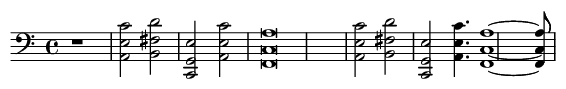

In [ ]:
def test_translation(name):
    hook_found = False
    for i in range(len(song_names)):
        if song_names[i] == name:
            hook_found = True
            events = encoded_dataset_ragged[i]
            translate_and_disp_chords(events)
    if not hook_found:
        print("No hooks with that name were found")

test_translation("Fall 4 U")

## Create input and target sequences to be fed into your RNN model

### First find the min, max and avg number of events per hook in your dataset

In [ ]:
def find_min_event_count():
    min_count = float("inf")
    name = ""
    for i in range(len(encoded_dataset_ragged)):
        hook = encoded_dataset_ragged[i]
        if len(hook) < min_count:
            min_count = len(hook)
            name = song_names[i]

    print(f"Min number of events in a hook: {min_count}")
    print(f"Song name with min: {name}\n")

def find_max_event_count():
    max_count = float("-inf")
    name = ""
    for i in range(len(encoded_dataset_ragged)):
        hook = encoded_dataset_ragged[i]
        if len(hook) > max_count:
            max_count = len(hook)
            name = song_names[i]

    print(f"Max number of events in a hook: {max_count}")
    print(f"Song name with min: {name}\n")

def find_avg_event_count():
    total_num_events = 0
    for hook in encoded_dataset_ragged:
        total_num_events += len(hook)
    
    avg = total_num_events / len(encoded_dataset_ragged)
    print(f"Avg number of events in a hook: {avg}")

find_min_event_count()
find_max_event_count()
find_avg_event_count()

Min number of events in a hook: 4
Song name with min: Natural Blues

Max number of events in a hook: 85
Song name with min: Roses ft ROZES

Avg number of events in a hook: 11.974465148378192


### Split dataset into input sequences and output vectors

If the length of the hook is smaller than seq_length + 1, just keep looping the hook until the length is >= seq_length + 1

In [ ]:
SEQ_LENGTH = 8

# Each input is a sequence of SEQ_LENGTH events. Output is the next event after the input sequence
inputs = []
outputs = []
song_names_long = []
num_hooks_expanded = 0

# Populate input and output lists
for i in range(len(encoded_dataset_ragged)):
    hook = encoded_dataset_ragged[i]
    concat_needed = False
    
    # If the hook doesn't have enough events, keep looping it until it does
    while len(hook) < SEQ_LENGTH + 1:
        concat_needed = True
        hook = hook + encoded_dataset_ragged[i]
    if concat_needed:
        num_hooks_expanded += 1

    # Now scan the hook
    for j in range(len(hook) - SEQ_LENGTH):
        inputs.append(hook[j:j + SEQ_LENGTH])
        outputs.append(hook[j + SEQ_LENGTH])
        song_names_long.append(song_names[i])

# Convert to numpy
inputs = np.array(inputs)
outputs = np.array(outputs)
print(f"Inputs shape: {inputs.shape}")
print(f"Outputs shape: {outputs.shape}")
print(f"Number of hooks that were expanded: {num_hooks_expanded}")



Inputs shape: (21904, 8, 42)
Outputs shape: (21904, 42)
Number of hooks that were expanded: 1369


## Create and compile RNN model

In [ ]:
input_length = inputs.shape[2]
print(f"Input length: {input_length}")
output_length = input_length

model = keras.Sequential([
    layers.Input(shape=(SEQ_LENGTH, input_length)),
    layers.LSTM(32, return_sequences=True),
    layers.LSTM(32, return_sequences=True),
    layers.LSTM(32),
    layers.Dense(output_length, activation="sigmoid")
])

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["binary_accuracy"])

model.summary()

Input length: 42
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 8, 32)             9600      
                                                                 
 lstm_31 (LSTM)              (None, 8, 32)             8320      
                                                                 
 lstm_32 (LSTM)              (None, 32)                8320      
                                                                 
 dense_10 (Dense)            (None, 42)                1386      
                                                                 
Total params: 27,626
Trainable params: 27,626
Non-trainable params: 0
_________________________________________________________________


## Write generation logic and test out untrained model

In [ ]:
a = np.array([1, 2, 3, 4])
a[-2:] = np.array([5, 6])
print(a)

[1 2 5 6]


In [ ]:
# Given an input idx, return an input sequence
# that is nicely reshaped for feeding into the model
def get_input(idx):
    input = inputs[idx].reshape(1, SEQ_LENGTH, input_length)
    return input

# Given an input sequence of events, predict the next event.
# Softmax temperature determines how random the sampling is
# (close to 0 is "harder" distribution, 1 is default softmax, and
# >1 is "softer" i.e. closer to uniform sampling).
def predict_next_event(input, temperature):
    # First, extract the pos value of the last input vector
    last_input_extract = input[0, -1, :]
    c_last, d_last, p_last = parse_event_vect(last_input_extract)
    last_pos_int = convert_pos_to_int_func(p_last)

    # Determine the pos for the prediction
    pred_pos_int = last_pos_int + decode_duration_one_hot(d_last)
    pred_pos = get_pos_func(pred_pos_int)

    # Feed input into model
    output = model(input)
    output = np.array(output[0, :]) # turn into 1D numpy vector

    # Extract chord, duration and measure vects and softmax them
    chord_vect, duration_vect, pos_vect = parse_event_vect(output)
    chord_vect = softmax(chord_vect / temperature)
    duration_vect = softmax(duration_vect / temperature)

    # Sample from softmax vectors
    chord_sample = np.random.multinomial(1, chord_vect)
    duration_sample = np.random.multinomial(1, duration_vect)
    a = CHORD_ONE_HOT_VECTOR_LENGTH
    pred_chord_idx = np.argmax(chord_sample)
    pred_duration_idx = np.argmax(duration_sample) + a

    # Return your predicted event as a flattened 1D numpy array
    prediction = np.zeros(output_length, dtype=int)
    prediction[pred_chord_idx] = 1
    prediction[pred_duration_idx] = 1
    prediction[-NUM_POS_BITS:] = pred_pos

    return prediction

# Given an input idx and softmax temperature (see above for explanation),
# generate 8 bars worth of events. Note that it's very easy to change
# the amount of output later if you want
def generate_hook(idx, temperature):
    # Setup
    hook = []
    total_dur = 0
    input = get_input(idx)

    # Keep making predictions until you fill up 128 timesteps (duration overshoots
    # allowed, though no new events allowed after step 127)
    while total_dur < NUM_16_NOTES_IN_8_BARS:
        # Make prediction and add to hook event list
        prediction = predict_next_event(input, temperature)
        chord_vect, duration_vect, pos_vect = parse_event_vect(prediction)
        dur = decode_duration_one_hot(duration_vect)
        hook.append(prediction)
        total_dur += dur

        # "Shift" the input sequence by one event
        prediction = prediction.reshape(1, 1, -1)
        input = np.concatenate((input[:, 1:, :], prediction), axis=1)

    # Show and play back the generated hook
    translate_and_disp_chords(hook)

# Use a random input idx to generate a hook with a given softmax temp
def generate_random_hook(temperature):
    idx = np.random.randint(0, len(inputs))
    name = song_names_long[idx]
    print(f"\nInput sequence from {name}:")
    translate_and_disp_chords(inputs[idx])
    print("\nGenerated output:")
    generate_hook(idx, temperature)

# Given a song name, generate a new hook using the first 4 events of that song's hook
# as input
def generate_hook_from_name(name, temperature):
    idx = 0
    hook_found = False
    for i in range(len(song_names_long)):
        if song_names_long[i] == name:
            idx = i
            hook_found = True
            break
    if not hook_found:
        print("No hook with that name was found!")
    else:
        print(f"\nInput sequence from {name}:")
        translate_and_disp_chords(inputs[idx])
        print("\nGenerated output:")
        generate_hook(idx, temperature)
        
# Sanity check
generate_hook_from_name("Hey Soul Sister", 1.0)

Output hidden; open in https://colab.research.google.com to view.

## Train model (skip if you want to load a pre-trained model)

In [ ]:
model.fit(inputs, outputs, epochs=20)

Epoch 1/20
685/685 [==============================] - 5s 7ms/step - loss: 0.0879 - binary_accuracy: 0.9658
Epoch 2/20
685/685 [==============================] - 5s 7ms/step - loss: 0.0860 - binary_accuracy: 0.9665
Epoch 3/20
685/685 [==============================] - 5s 7ms/step - loss: 0.0844 - binary_accuracy: 0.9672
Epoch 4/20
685/685 [==============================] - 4s 7ms/step - loss: 0.0827 - binary_accuracy: 0.9681
Epoch 5/20
685/685 [==============================] - 5s 7ms/step - loss: 0.0809 - binary_accuracy: 0.9688
Epoch 6/20
685/685 [==============================] - 4s 7ms/step - loss: 0.0796 - binary_accuracy: 0.9695
Epoch 7/20
685/685 [==============================] - 4s 6ms/step - loss: 0.0780 - binary_accuracy: 0.9701
Epoch 8/20
685/685 [==============================] - 5s 7ms/step - loss: 0.0766 - binary_accuracy: 0.9709
Epoch 9/20
685/685 [==============================] - 5s 7ms/step - loss: 0.0752 - binary_accuracy: 0.9714
Epoch 10/20
685/685 [================

## Generate some chords!

In [ ]:
temp = 0.12
generate_random_hook(temp)
generate_hook_from_name("We Found Love Ft Calvin Harris", temp)

Output hidden; open in https://colab.research.google.com to view.